In [1]:
import pandas as pd
import numpy as np

In [2]:
## Open file
number_samples = 6
bracken_file=pd.read_csv(filepath_or_buffer='/Volumes/PiconCossio/biocomp_tools/MAUS/utils/all_bracken_report_V3-V4.txt', 
                        delimiter='\t', skiprows=8)

In [3]:
import os
alpha_diversity_raw={"sample":[], "shannon":[], "simpson_reciprocal":[]}
for i in os.listdir():
    if i.startswith("G"):
        handler=open(i)
        handler=handler.readlines()
        ## select lines 0 and 3 which are Shannon and Simpson's Reciprocal Index
        alpha_diversity_raw["sample"].append(i[:4])
        alpha_diversity_raw["shannon"].append(round(float(handler[0].split(" ")[2].strip()),2))
        alpha_diversity_raw["simpson_reciprocal"].append(round(float(handler[3].split(" ")[3].strip()),2))
alpha_data=pd.DataFrame(alpha_diversity_raw)
alpha_data.sort_values(by="sample",inplace=True)

In [4]:
## compute relative abundance (RelAbun)
def compute_relative_abun (df, number_samples=6):
    for i in range(1, number_samples+1):
        i = str(i)
        df[f"G{i}_1_RelAbun"] = df[f"G{i}_1_lvl"]/df[f"G{i}_1_lvl"].sum() * 100
    return df

In [5]:
bracken_file=compute_relative_abun(df=bracken_file, number_samples=number_samples)
min_abundance=1
def filter_by_abundance_conditional (df, number_samples, min_abundance, min_samples):
    ## This is intended to mimic the taxa filter by abundance conditionally of qiime2
    ## Select taxa that have at least n abundance in at least n samples 
    df = df[(df.iloc[:,number_samples*-1:] >= min_abundance).sum(axis=1) >= min_samples]
    return df

bracken_file = filter_by_abundance_conditional (df=bracken_file, 
                                                number_samples=number_samples,
                                                min_abundance=min_abundance, 
                                                min_samples=2)
bracken_file=compute_relative_abun(df=bracken_file, number_samples=number_samples)

In [6]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [7]:
bracken_file_relative_abun=bracken_file.loc[:,"name":]
fig = make_subplots(rows=2, cols=1, shared_xaxes=False)

sample_names=bracken_file_relative_abun.iloc[:,1:].columns
bracken_file_relative_abun["name"] = bracken_file_relative_abun["name"].apply(lambda x:x.strip())

# Number of bars
num_bars = len(bracken_file_relative_abun["name"])

# Generate colors using a predefined colorscale (Viridis, Cividis, etc.)
colors = px.colors.sample_colorscale('spectral', np.linspace(0, 1, num_bars))

## Composition bars
for i in range(0, len(bracken_file_relative_abun["name"])):
        fig.add_bar(name=bracken_file_relative_abun.iloc[i,0].strip(),
                        x=sample_names,y=bracken_file_relative_abun.iloc[i,1:],
                        row=2, col=1, marker=dict(color=colors[i])
                    )

## Diversity bars
width=0.4
offset=0.2
y = alpha_data["shannon"].to_list()
x_values=np.linspace(1, len(y), len(y))
fig.add_bar(name="Shannon", x=x_values,y=y, showlegend=False,
                        row=1, col=1, width=width,offset=offset,
                        text=[str(i) for i in y], textangle=360,
                    )
fig.add_bar(name="Simpson",x=x_values, y=alpha_data["simpson_reciprocal"], showlegend=False,
                        row=1, col=1, width=width,
                        text="simpson", textangle=360,
                    )

fig.update_layout(barmode='stack',
    autosize=True,
    width=1200,
    height=800,
    title_text="Relative abundance V3-V4 Kraken2-Bracken"
    )


## Composition bars

fig.update_yaxes(title_text="Relative frequency (%)", row=2, col=1)
fig.update_xaxes(title_text="Samples", row=2, col=1)

## Diversity bars
fig.update_traces(dict(base='group'), row=1, col=1, overwrite=True)
fig.update_yaxes(dict(title_text="Value", tickmode="linear", tick0=0, dtick=5), row=1, col=1, overwrite=True)
fig.update_xaxes(title_text="Alpha diversity", row=1, col=1, tickvals=x_values ,ticktext=["Shannon"] * len(y))

#fig.write_image('kraken2_barplots.png', format='png')

In [8]:
alpha_data

,sample,shannon,simpson_reciprocal
0,G1_1,4.40,34.59
1,G2_1,3.69,16.35
2,G3_1,3.94,18.05
3,G4_1,3.77,14.49
4,G5_1,4.08,21.26
5,G6_1,3.77,15.41


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
duplicates=bracken_file_relative_abun["name"].duplicated()
for i in bracken_file_relative_abun[duplicates].index:
    bracken_file_relative_abun.loc[i,"name"] = bracken_file_relative_abun.loc[i,"name"] + str(i)
bracken_file_relative_abun.set_index(keys="name",inplace=True)
bracken_file_relative_abun.head()

,G1_1_RelAbun,G2_1_RelAbun,G3_1_RelAbun,G4_1_RelAbun,G5_1_RelAbun,G6_1_RelAbun
name,,,,,,
Pseudomonas,8.204051,1.200776,35.370228,33.303309,22.392264,21.969841
Parapusillimonas,0.188801,0.032415,0.343559,2.847241,1.849021,0.452189
Lampropedia,0.013172,0.406138,17.073114,0.538406,0.652705,3.243311
Burkholderia-Caballeronia-Paraburkholderia,0.933759,1.533981,3.658025,2.045739,0.830211,0.557045
Haemophilus,0.005123,0.022404,0.026786,3.407021,4.003747,3.512658


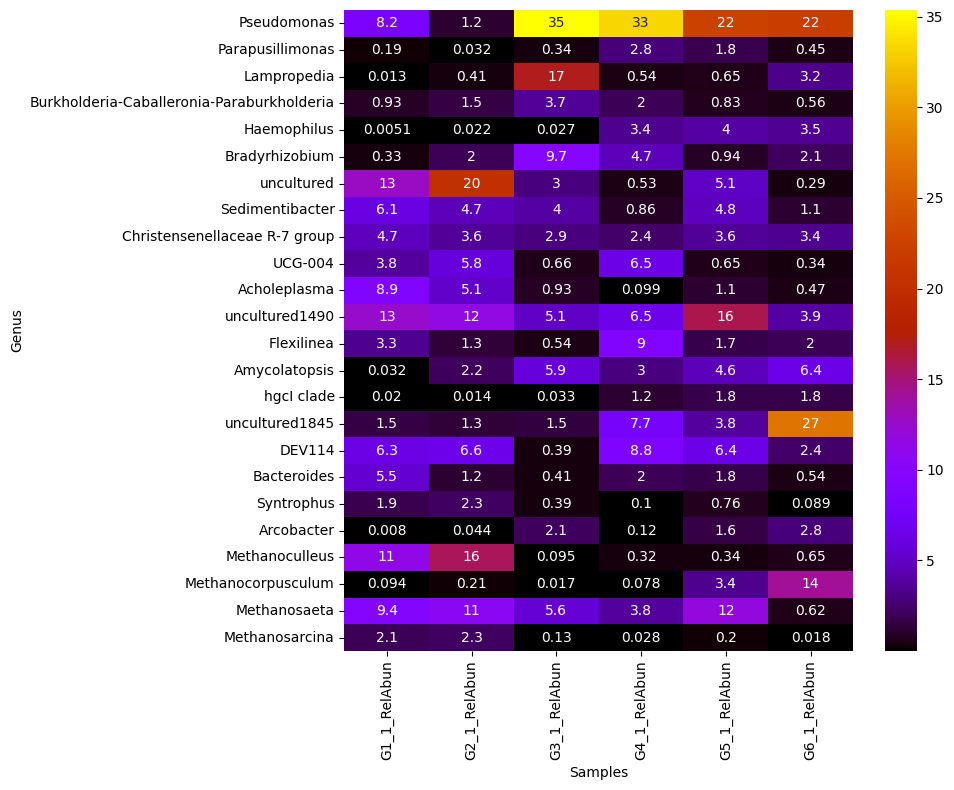

In [11]:
fig = plt.figure(figsize=(10,8))
heatmap=sns.heatmap(bracken_file_relative_abun, cmap="gnuplot", annot=True)
heatmap.set_ylabel("Genus")
heatmap.set_xlabel("Samples")
plt.xticks(rotation=90)
plt.tight_layout()
#fig.savefig('heatmap_samples_vs_genus.png', format='png', dpi=1200)

<Figure size 1000x800 with 0 Axes>

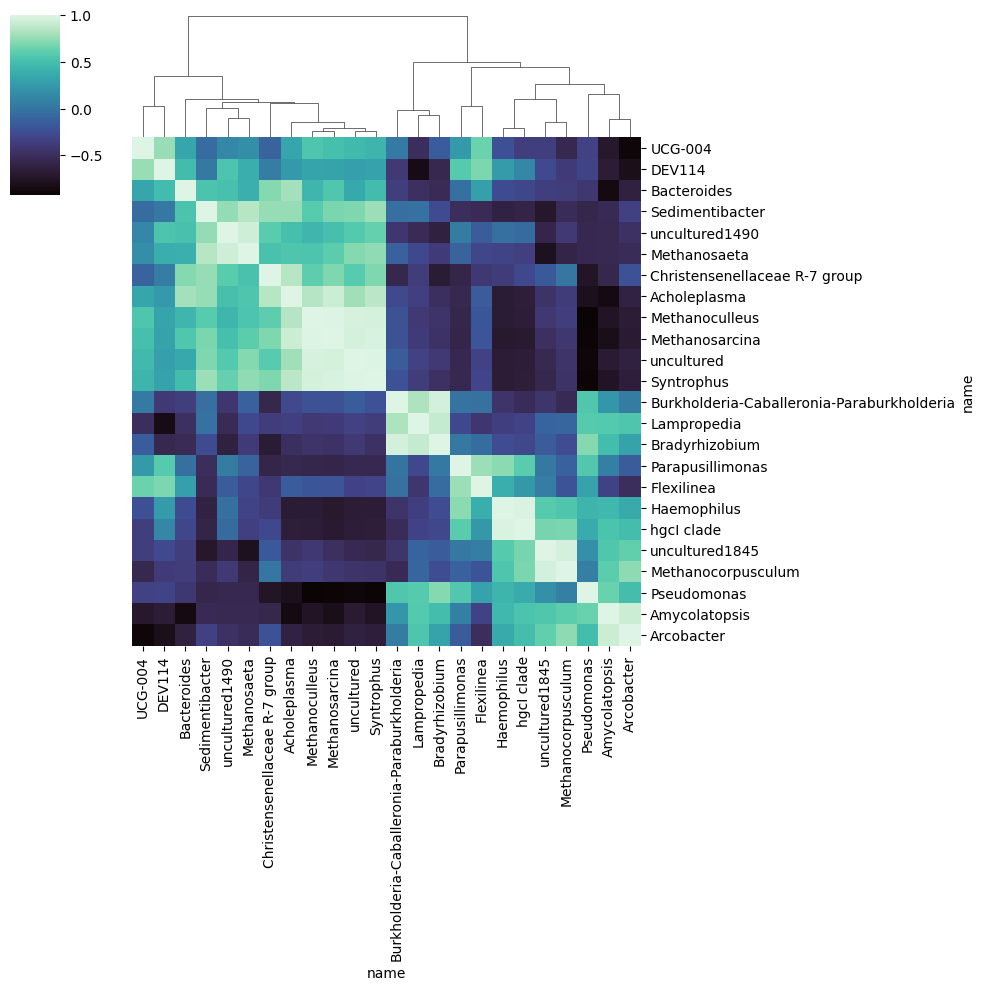

In [12]:
fig = plt.figure(figsize=(10,8))
correlation=bracken_file_relative_abun.T.corr()
cluster_plot = sns.clustermap(correlation, cmap="mako")
cluster_plot.ax_row_dendrogram.remove()
#fig.savefig('clustermap_samples_vs_genus.png', format='png', dpi=1200)
#cluster_plot.savefig('clustermap_samples_vs_genus.png', format='png', dpi=1200)

In [13]:
import re
keep_columns = re.findall("G\d+_\d+_lvl", " ".join(bracken_file.columns))


In [14]:
cluster=bracken_file[keep_columns + ["name"]]
cluster.iloc[:,:-1] = cluster.iloc[:,:-1].apply(lambda x: np.log10(x + 1))
cluster.set_index(keys="name", inplace=True)

<Figure size 1000x800 with 0 Axes>

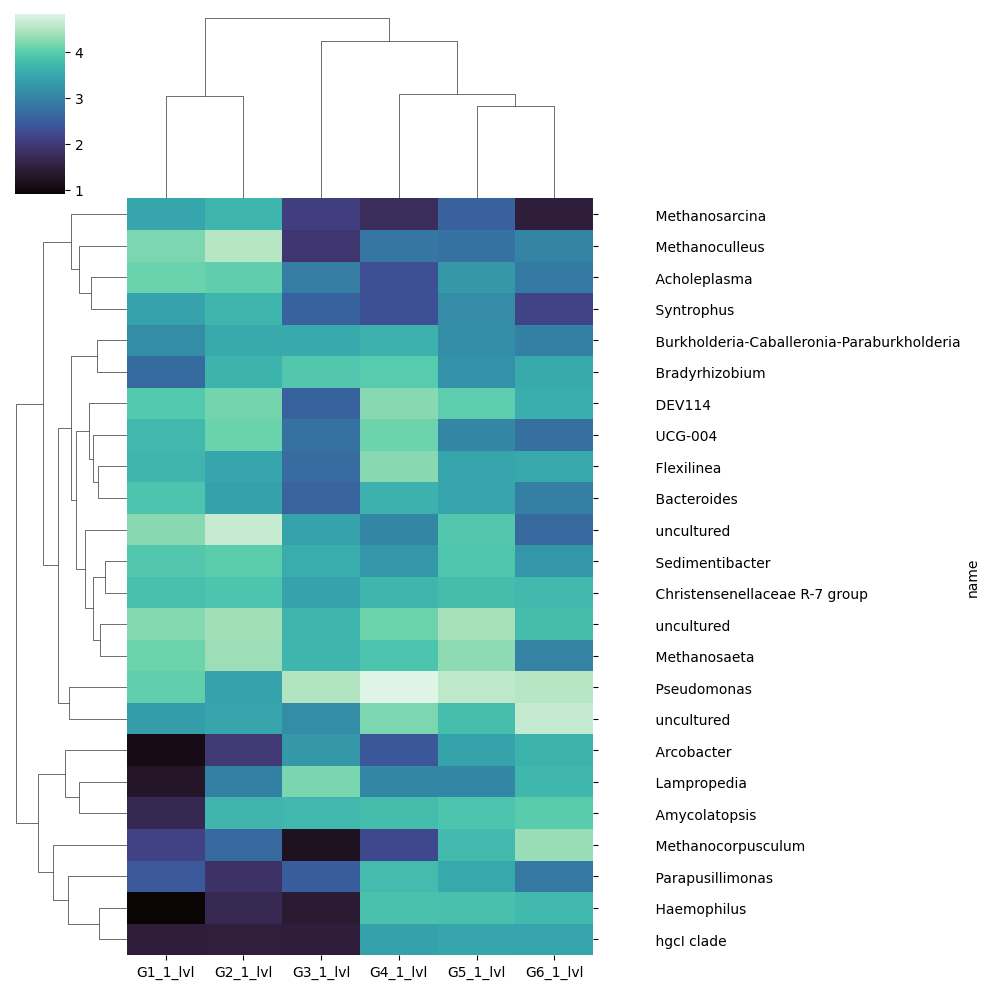

In [15]:
fig = plt.figure(figsize=(10,8))
cluster_plot = sns.clustermap(cluster, cmap="mako")
#cluster_plot.ax_row_dendrogram.remove()
#cluster_plot.savefig('clustermap_samples_vs_genus.png', format='png', dpi=1200)

# Beta diversity (Bray-Curtis with PCoA)

In [16]:
beta_matrix=pd.read_csv(filepath_or_buffer="/Volumes/PiconCossio/biocomp_tools/MAUS/utils/beta_diversity_V3-V4.txt", delimiter="\t", skiprows=6, index_col=0)
matrix=beta_matrix.to_numpy()
i_lower = np.tril_indices(matrix.shape[0], -1)  # Indices for the lower triangle
matrix[i_lower] = matrix.T[i_lower] 
matrix

array([['0.000', '0.439', '0.705', '0.589', '0.504', 0.649],
       ['0.439', '0.000', '0.702', '0.580', '0.471', 0.676],
       ['0.705', '0.702', '0.000', '0.590', '0.583', 0.564],
       ['0.589', '0.580', '0.590', '0.000', '0.420', 0.483],
       ['0.504', '0.471', '0.583', '0.420', '0.000', 0.403],
       [0.649, 0.676, 0.564, 0.483, 0.403, 0.0]], dtype=object)

In [17]:
from skbio.stats.ordination import pcoa

In [18]:
pcoa_result = pcoa(matrix, number_of_dimensions=2)

In [19]:
coordinates = pcoa_result.samples
coordinates.reset_index(inplace=True)
coordinates["index"]=coordinates["index"].astype(int)+1
coordinates

,index,PC1,PC2
0,1,-0.303731,0.062821
1,2,-0.316441,0.075245
2,3,0.302978,0.327391
3,4,0.084400,-0.148558
4,5,-0.003068,-0.129668
5,6,0.235862,-0.187231


Text(0.5, 1.0, 'Beta diversity PCoA')

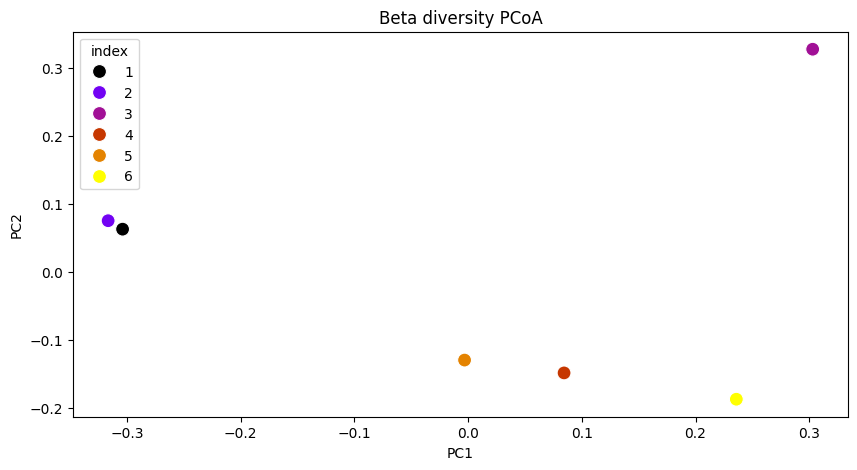

In [20]:
fig = plt.figure(figsize=(10,5))
sns.scatterplot(coordinates, x="PC1",y="PC2", hue="index", palette="gnuplot", s=100)
plt.title("Beta diversity PCoA")
#fig.savefig('Beta_diversity_PCoA.png', format='png', dpi=1200)